Transformer

**Author:** [Divyanshu Raghuwanshi]()<br>
**Date created:** 2021/03/31<br>
**Last modified:** 2021/03/31<br>
**Description:** Implement a Transformer block as a Keras layer and use it for fault classification.

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import drive

In [ ]:
import sys
!{sys.executable} -m pip install xlsxwriter

     |████████████████████████████████| 148 kB 4.9 MB/s 


In [ ]:
import xlsxwriter

## Implement a Transformer block as a layer

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, maxlen, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        
        self.ffn = keras.Sequential(
            [layers.LSTM(48, input_shape=(maxlen,embed_dim), return_sequences=True),layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        #self.ffn = keras.Sequential(
        #   [layers.LSTM(16, input_shape=(maxlen,embed_dim),]
        #)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).

In [ ]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        #self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        #x = self.token_emb(x)
        return x + positions


## Download and prepare dataset

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Research data/MeggitSummaryCSV.csv')

In [ ]:
Xdf=df.iloc[:,2:18]
Xdf=Xdf.values
ydf=df.iloc[:,-1]
ydf=ydf.values

In [ ]:
Xdf.shape,ydf.shape

((394716, 16), (394716,))

In [ ]:
def prepareData(X,y,W,s_W):
  #X,y = removeNAN(X,y)
  #X,y = removeNULL(X,y)
  # Standardizing with z-score
  #X = stats.zscore(X,axis = 0)
  X_data=list()
  y_data=list()
  
  L=0
  R=W
  
  while(R <= X.shape[0]):
      #print('{}:{}'.format(L,R))
      sample=X[L:R]
      label=y[L:R]
      if len(set(label))==1 and len(label)==W:
          X_data.append(sample)
          y_data.append(label[0])

      L=L+s_W
      R=R+s_W

  X=np.array(X_data)
  y=np.array(y_data)
  return X,y

In [ ]:
import numpy as np
W=120
s_W=60
#dataX, datay = prepareData(X,y,W,s_W)
dataX, datay = prepareData(Xdf,ydf,W,s_W)

In [ ]:
dataX.shape,datay.shape

((6567, 120, 16), (6567,))

In [ ]:
def load_dataset():
  X_train, X_val, y_train, y_val = train_test_split(dataX[:,:,:], datay[:], test_size=0.20, random_state=1)
  X_train, X_test, y_train, y_test = train_test_split(X_train[:,:,:], y_train[:], test_size=0.10, random_state=1)
  return X_train, X_test, X_val, y_train, y_test, y_val

## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.

## Train and Evaluate

In [ ]:
import time
def evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, epochs):
    maxlen=120
    embed_dim = 16  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    #epochs = 50
    Verbose = 0
    Batch_size=84

    inputs = layers.Input(shape=(maxlen,embed_dim))
    embedding_layer = PositionEmbedding(maxlen, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(maxlen, embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    #x = layers.Dense(10, activation="relu")(x)
    #x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(6, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    
    tictr = time.perf_counter()
    history=model.fit(X_train, y_train, batch_size=Batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=Verbose)
    toctr = time.perf_counter()
    training_time = toctr-tictr

    # evaluate model
    pred = model.predict(X_test)

    tict=time.perf_counter()
    _, accuracy = model.evaluate(X_test, y_test, batch_size=Batch_size, verbose=Verbose)
    toct=time.perf_counter()
    testing_time = toct-tict


    return accuracy, history ,y_test, pred, training_time, testing_time

In [ ]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
    fullCatWriter = pd.ExcelWriter('/A+LSTM_Result.xlsx', engine='xlsxwriter')     
    dataframe1 = pd.DataFrame(scores, columns =['Accuracy'], dtype = float)            
    dataframe1.to_excel(fullCatWriter, sheet_name='Full Raw', startrow=0 , startcol=0)            
    fullCatWriter.save()      
    fullCatWriter.close()  

In [ ]:
def exec_time(tstimel, trtimel):
    dict={'training_time':trtimel, 'testing_time':tstimel}
    fullCatWriter = pd.ExcelWriter('/A+FFN_execution_time.xlsx', engine='xlsxwriter')     
    dataframe1 = pd.DataFrame(data=dict, dtype = float)            
    dataframe1.to_excel(fullCatWriter, sheet_name='Full Raw', startrow=0 , startcol=0)            
    fullCatWriter.save()      
    fullCatWriter.close()

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curves(history,epochs,ind):
  hacc=np.array(history.history['accuracy'])
  hvacc=np.array(history.history['val_accuracy'])
  loss=np.array(history.history['loss'])
  vloss=np.array(history.history['val_loss'])

  u = np.arange(0, epochs) 
  plt.plot(u,hacc)
  plt.plot(u,hvacc)
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train','val'], loc='lower right')
  fig1 = plt.gcf()
  plt.show()
  fig1.savefig("A+LSTM_acc%d.pdf"%ind)

  plt.plot(u,loss)
  plt.plot(u,vloss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train','val'], loc='upper right')
  fig2 = plt.gcf()
  plt.show()
  fig2.savefig("A+LSTM_loss%d.pdf"%ind)

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sn
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
def plot_CM_and_find_prec_rec_f1(y,pred,ind):
  pred=np.argmax(pred, axis=-1)
  
  labels=['HL','S_UB','C_UB', 'D_UB', 'MA', 'LS']
  mat=confusion_matrix(y,pred)
  mat=mat/mat.astype(np.float).sum(axis=1)

  df_cm = pd.DataFrame(mat, range(6), range(6))
  sn.set(font_scale=1.0) # for label size
  fig=sn.heatmap(df_cm,cmap="Blues", annot=True, annot_kws={"size": 14}, square=True, xticklabels=labels, yticklabels=labels) # font size
  fig.set(xlabel="Predicted Label", ylabel = "True Label")
  plt.yticks(rotation=0)
  plt.savefig('A+LSTM_CMsb%d.pdf'%ind, bbox_inches='tight')
  plt.show()
  
  Report=pd.DataFrame(classification_report(y, pred, target_names=labels, output_dict=True))
  Report.to_csv('/A+LSTM_Classification_Report%d.csv'%ind, index = True)

In [ ]:
def run_experiment(epochs, repeats=2):
	# load data
	# repeat experiment
  scores = list()
  trtimelst = list()
  tstimelst = list()

  X_train, X_test, X_val, y_train, y_test, y_val = load_dataset()
  for r in range(repeats):
    score,history,y,pred,trtime,tstime = evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, epochs)
    score = score * 100.0
    print('>#%d: %.3f' % (r+1, score))
    print('>#%d: %0.4f'%(r+1,trtime))
    print('>#%d: %0.4f'%(r+1,tstime))

    scores.append(score)
    trtimelst.append(trtime)
    tstimelst.append(tstime)

    plot_learning_curves(history, epochs, r)
    
    plot_CM_and_find_prec_rec_f1(y, pred, r)
  
  summarize_results(scores)
  exec_time(trtimel=trtimelst, tstimel=tstimelst)

>#1: 98.479
>#1: 685.0702
>#1: 0.4354


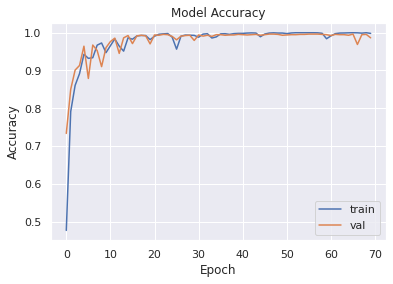

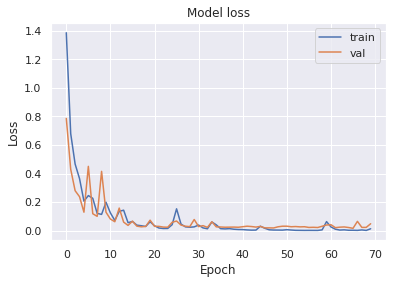

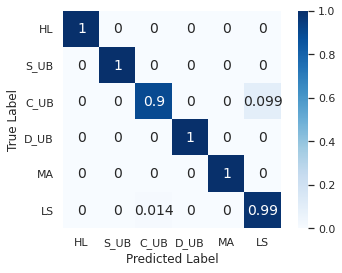

>#2: 99.620
>#2: 670.9575
>#2: 0.4077


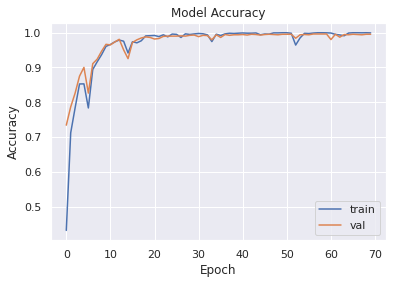

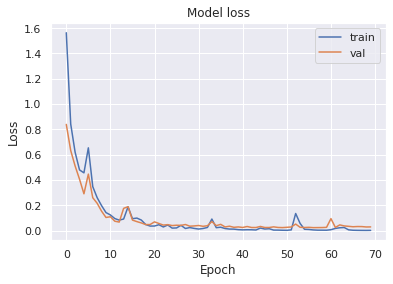

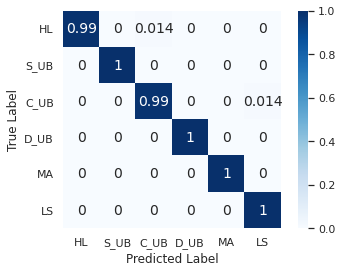

[98.47908616065979, 99.61977005004883]
Accuracy: 99.049% (+/-0.570)


/usr/local/lib/python3.7/dist-packages/xlsxwriter/workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [ ]:
epochs= 70
run_experiment(epochs)

#ROUGH EXPERIMENTATION

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(dataX[:,:,:], datay[:], test_size=0.20, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train[:,:,:], y_train[:], test_size=0.10, random_state=1)

In [ ]:
X_train.shape

(4727, 120, 16)

In [ ]:
X_val.shape

(1314, 120, 16)

In [ ]:
X_test.shape

(526, 120, 16)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(dataX[:,:,:], datay[:], test_size=0.20, random_state=1)

In [ ]:
maxlen=120
embed_dim = 16  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
epochs = 5
Verbose = 0
Batch_size=84

inputs = layers.Input(shape=(maxlen,embed_dim))
embedding_layer = PositionEmbedding(maxlen, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(maxlen, embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(6, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=Batch_size, epochs=epochs, verbose=Verbose)


In [ ]:
pred=model.predict(X_test[0:3])
np.argmax(pred, axis=-1)

In [ ]:
y_test[0:3]

In [ ]:
maxlen=120
embed_dim = 16  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
epochs = 5
Verbose = 0
Batch_size=84

inputs = layers.Input(shape=(maxlen,embed_dim))
embedding_layer = PositionEmbedding(maxlen, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(maxlen, embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
#x = layers.Dense(20, activation="relu")(x)
x = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(6, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 16)]         0         
_________________________________________________________________
position_embedding_2 (Positi (None, 120, 16)           1920      
_________________________________________________________________
transformer_block_1 (Transfo (None, 120, 16)           16800     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                170       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0   